In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer
import math
from matplotlib import pyplot as plt
import random
from scipy.optimize import minimize
from qiskit.circuit.library import RZZGate
import networkx as nx

In [2]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
import random
from collections import Counter
import seaborn as sns
import pandas as pd

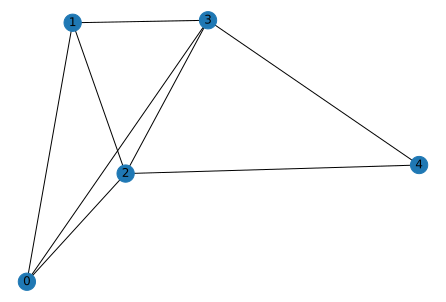

In [3]:
np.random.seed(50)
n_nodes=5
graph = [(0,1,1.0),(1,2,9.0),(0,2,7.0),(3,1,5),(2,3,3.0),(0,3,1.0),(4,3,1),(4,2,1)]
G=nx.Graph()
G.add_weighted_edges_from(graph)
nx.draw(G,with_labels=True)

In [4]:
N = n_nodes
A=np.zeros((int(N),int(N)))
for i in graph:
    A[i[0]][i[1]] = i[2]
    A[i[1]][i[0]] = i[2]

In [5]:
def initialization(circuit):
    for qubit in circuit.qubits:
        circuit.h(qubit)
    return circuit

def cost_unitary_layer(circuit, gamma):
    for edge in graph:
        op = RZZGate(gamma*edge[2])
        circuit.append(op, [edge[0],edge[1]])
    #circuit.barrier()
    return circuit

def mixture_unitary_layer(circuit,alpha):
    for qubit in circuit.qubits:
        circuit.rx(alpha,qubit)
    #circuit.barrier()
    return circuit

def create_params(params):
    alphas = []
    gammas = []
    for i in range(int(len(params)/2)):
        gammas.append(params[2*i])
        alphas.append(params[2*i+1])
    return gammas , alphas

def first_guess_linear(p,m1=0.5,m2=0.5):
    theta=np.zeros([2*p])
    for i in range(2*p):
        if i % 2 ==0:
            theta[i]=m1*(i+1)/(2*p)
        else:
            theta[i]=m2*(2*p-i)/(2*p)
    return(theta)

In [6]:
def anasatz(gammas, alphas, p, N):
    q = QuantumRegister(N)
    c = ClassicalRegister(N)
    circuit = QuantumCircuit(q,c)
    circuit = initialization(circuit)
    for i in range(p):
        circuit = cost_unitary_layer(circuit, gammas[i])
        circuit = mixture_unitary_layer(circuit,alphas[i])
    return circuit

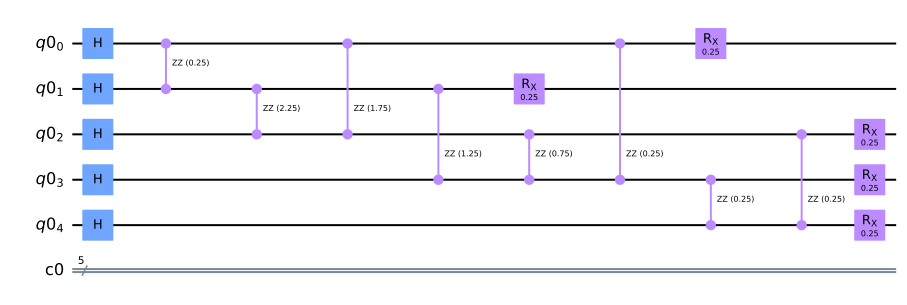

In [7]:
gammas, alphas = create_params(first_guess_linear(1,m1=0.5,m2=0.5))
circuit = anasatz(gammas, alphas,1,5)
circuit.draw('mpl')

In [8]:
import cotengra as ctg

opt = ctg.ReusableHyperOptimizer(
    reconf_opts={},
    max_repeats=16,
    parallel=True,
    
)

C:\Users\EXPERT\anaconda3\lib\site-packages\cotengra\hyper.py:20: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "


In [41]:
def cost_function(params):
    gammas, alphas = create_params(params)
    layer = int(len(gammas))
    circ = anasatz(gammas, alphas, layer,n)
    qasm = circ.qasm()
    #print(qasm)
    d = parse_qasm_from_qiskit(qasm)
    circtn = qtn.Circuit(d["n"])
    circtn.apply_gates(d["gates"])
    
    ZZ = qu.pauli('Z') & qu.pauli('Z')
    expns = [circtn.local_expectation(edge[2]*ZZ, (edge[0], edge[1]),optimize=opt) for edge in graph]
    cost = 0.5*(sum(expns).real)
    return cost

def create_bitstrings(opt_params):
    opt_gammas, opt_alphas = create_params(opt_params)
    opt_circ = anasatz(opt_gammas, opt_alphas, p,n)
    opt_qasm = opt_circ.qasm()
    d = parse_qasm_from_qiskit(opt_qasm)
    opt_circtn = qtn.Circuit(d["n"])
    opt_circtn.apply_gates(d["gates"])
    bitstrings = Counter(opt_circtn.sample(1000))
    return bitstrings

def get_approximation_ratio(z,b):
    c_z = 0
    c_z_max = 0
    z_a =array_of_key(z)
    for edge in graph:
        c_z = c_z + edge[2]*(1/2)*(1-((1-2*z_a[edge[0]])*(1-2*z_a[edge[1]])))
    for edge in graph:
        c_z_max = c_z_max + edge[2]*(1/2)*(1-((1-2*b[edge[0]])*(1-2*b[edge[1]])))
    app_ratio = c_z / c_z_max
    return app_ratio

def get_maximum_z(counts):
    maximum = 0
    z = ''
    for key in counts.keys():
        if counts[key] > maximum:
            maximum = counts[key]
            z = key 
    prob = maximum/1000
    return z, prob

def array_of_key(key):
    hold=[]
    for i in range(0,len(key)):
        hold.append(int(key[i]))
    return hold

In [42]:
best_cost_brute = 0
for b in range(2**N):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(N)))]
    cost = 0
    for i in range(N):
        for j in range(N):
            cost = cost + A[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))
brute = xbest_brute


Best solution = [0, 0, 1, 1, 0] cost = 24.0


In [52]:
def parse_qasm_from_qiskit(qasm):
    lines = qasm.split('\n')
    n = int(lines[2][-3])
    
    gates = []
    for l in lines[4:-1]:
        term = [l.split(" ")[0], l.split(" ")[1][:-1]]
        #print(term)
        arg =0
        num =0
        dem =0
        gate_info = []
        a = term[0].split("(", 1)
        if len(a) != 1:
            b = a[1][:-1]
            c = b.split("/")
            if len(c) == 1:
                arg = float(c[0])
            else:
                for i in range(len(c)):
                    d = c[i].split("*")
                    if len(d) != 1:
                        d = c[i][c[i].find("(")+1:c[i].rfind(")")]
                        #print("d",d)
                        e = d.split("*")
                        x = e[1]    
                        exec("%s = %f" % (x,np.pi))
                        #print(pi)
                        if i == 0:
                            num = float(e[0])*(np.pi)
                        
                        if i == 1:
                            dem = float(e[0])*(np.pi)
                    else:
                        if i == 0:
                            if d[0] == "pi":
                                num = np.pi
                            else:
                                num = float(d[0])
                        if i == 1:
                            if d[0] == "pi":
                                dem = np.pi
                            else:
                                dem = float(d[0])
                arg = num/dem
               
            gate_info = [a[0], arg]
        else:
            gate_info = a[0]
        #print(gate_info)
        qubits_info = term[1].split(",")
        final_info = []
        for i in gate_info:
            final_info.append(i)
        for i in range(len(qubits_info)):
            final_info.append(int((qubits_info[i].split("["))[1][-2]))
            
        #print(final_info)
        gates.append(final_info)
        
    n_gates = len(gates)
    
    return {"n":n, "gates":gates, "n_gates":n_gates}

In [57]:
ZZ = qu.pauli('Z') & qu.pauli('Z')
n=n_nodes
data_final = pd.DataFrame(columns=[["inital angles" ,  "optimal angles", "opt obj value","p", "optimizer"
                                    ,"ground prob",  "approx ratio"]])
rehss = []
trees = []
flops = []
widths = []
contraction_costs = []
theta = []
for p in range(1,11):
    print('layer :', p)
    
    if len(theta) == 0:
        theta = first_guess_linear(1,m1=0.5,m2=0.5)
        
    init_params = theta
    
    
    gammas, alphas = create_params(init_params)
    circ = anasatz(gammas, alphas,p, N)
    qasm = circ.qasm()
    d = parse_qasm_from_qiskit(qasm)
    circtn = qtn.Circuit(d["n"])
    circtn.apply_gates(d["gates"])
    local_exp_rehs = [circtn.local_expectation_rehearse(edge[2]*ZZ, (edge[0], edge[1]),optimize=opt) for edge in graph]
    edge_wise_rehs = []
    edge_wise_trees = []
    edge_wise_flops = []
    edge_wise_widths = []
    edge_wise_contraction_costs = []
    for rehs in local_exp_rehs:
        edge_wise_rehs.append(rehs)
        edge_wise_widths.append(rehs['W'])
        edge_wise_contraction_costs.append(rehs['C'])
        tree = ctg.ContractionTree.from_info(rehs['info'])
        edge_wise_trees.append(tree)
        edge_wise_flops.append(tree.total_flops())
        
    rehss.append(edge_wise_rehs)
    trees.append(edge_wise_trees)
    flops.append(edge_wise_flops)
    widths.append(edge_wise_widths)
    contraction_costs.append(edge_wise_contraction_costs)
    
    method = "COBYLA"
    print("Initial Guess\n", init_params)
    out = minimize(cost_function, x0=init_params, method=method, options={'maxiter':300})
    print(out)
    bitstrings = create_bitstrings(out.x)
    
    z , prob = get_maximum_z(bitstrings)
    print("z with maximum frequency: "+str(z))
    r = get_approximation_ratio(z,brute)
    print("approxiamation ratio: "+str(r))
    gse = out.fun
    print("gse: "+str(gse))
    print("prob of maxm string: "+str(prob))
    
    
    
    data = pd.DataFrame([ [init_params], [out.x],[gse], [p], [method],[prob], [r]]) 
    
    data = data.T
    
    data.columns=[["inital angles" ,  "optimal angles", "opt obj value", "p", "optimizer", "ground prob",  "approx ratio"]]

    data_final = data_final.append(data)
    theta = list(out.x)
    for i in range(2):
        theta.append(0)
    print("-------------------------------------------------------------------------------------------------------------------")

layer : 1
Initial Guess
 [0.25 0.25]
     fun: -4.891726639040864
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 300
  status: 2
 success: False
       x: array([0.21298073, 1.33458859])
z with maximum frequency: 00110
approxiamation ratio: 1.0
gse: -4.891726639040864
prob of maxm string: 0.113
-------------------------------------------------------------------------------------------------------------------
layer : 2
Initial Guess
 [0.21298072532095214, 1.3345885867851632, 0, 0]
     fun: -5.034375653443358
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 300
  status: 2
 success: False
       x: array([0.20637186, 1.35310885, 0.07128159, 0.12286582])
z with maximum frequency: 11001
approxiamation ratio: 1.0
gse: -5.034375653443358
prob of maxm string: 0.111
-------------------------------------------------------------------------------------------------------------------
layer : 3
Initial Gues

In [58]:
def plot_histo(data_final, y, optimizer):
    df = pd.DataFrame(np.array(data_final[y].values))
    df.columns = ['a']
    df.index += 1
    df = df.T
    df.columns = ["p_"+str(i) for i in range(1,11)]
    df['optimizer'] = [optimizer]
    print (df)
    solts=  df.melt(id_vars='optimizer').rename(columns=str.title)
    titanic = sns.load_dataset("titanic")
    sns.catplot(x="Optimizer", y="Value",  hue='Variable', kind="bar", data=solts)
    
def plot_line_graph(y):
    #plt.figure(figsize=(10,7))
    x = np.array(range(1,11))
   
    plt.plot(x,y, "-o")
   
    #plt.legend(["COBYLA", "Nelder-Mead", "BFGS"], loc ="lower right")
    plt.xlabel("layers")
    plt.ylabel(y)
    plt.show()

approx ratio
   p_1  p_2       p_3       p_4       p_5       p_6       p_7       p_8  \
a  1.0  1.0  0.916667  0.916667  0.916667  0.916667  0.916667  0.916667   

        p_9      p_10 optimizer  
a  0.916667  0.916667     skopt  


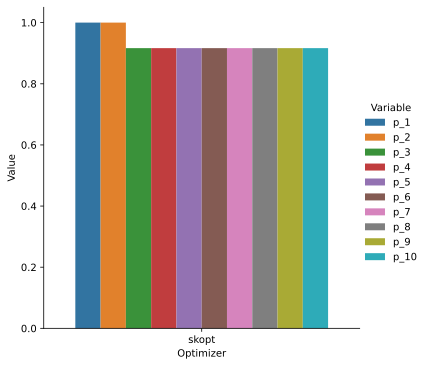

In [59]:
op = "skopt"
y = "approx ratio"
print("approx ratio")
plot_histo(data_final, y, op)

ground state
        p_1       p_2       p_3       p_4       p_5       p_6       p_7  \
a -4.891727 -5.034376 -5.083753 -5.986554 -6.320311 -6.569857 -6.758551   

        p_8       p_9      p_10 optimizer  
a -6.869658 -6.932228 -6.985676     skopt  


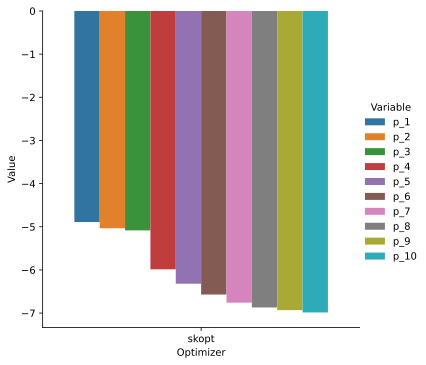

In [60]:
print("ground state")
y = "opt obj value"
plot_histo(data_final, y, op)

Frequency of the optimal bitstring
     p_1    p_2    p_3    p_4    p_5    p_6    p_7    p_8    p_9   p_10  \
a  0.113  0.111  0.119  0.194  0.238  0.276  0.272  0.298  0.306  0.309   

  optimizer  
a     skopt  


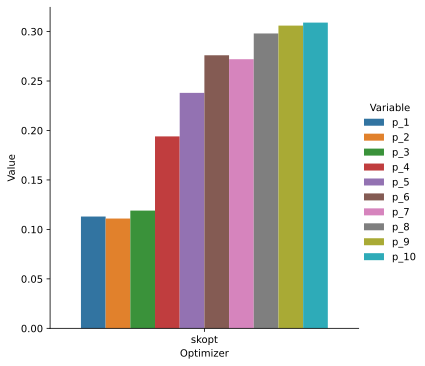

In [61]:
print("Frequency of the optimal bitstring")
y = "ground prob"
plot_histo(data_final, y, op)

In [62]:
data_final

,inital angles,optimal angles,opt obj value,p,optimizer,ground prob,approx ratio
0,"[0.25, 0.25]","[0.21298072532095214, 1.3345885867851632]",-4.891727,1,COBYLA,0.113,1.0
0,"[0.21298072532095214, 1.3345885867851632, 0, 0]","[0.2063718648955376, 1.3531088529972908, 0.071...",-5.034376,2,COBYLA,0.111,1.0
0,"[0.2063718648955376, 1.3531088529972908, 0.071...","[0.20158509599995506, 1.388327004543823, 0.072...",-5.083753,3,COBYLA,0.119,0.916667
0,"[0.20158509599995506, 1.388327004543823, 0.072...","[0.20361066207794548, 1.4440611579610483, 0.09...",-5.986554,4,COBYLA,0.194,0.916667
0,"[0.20361066207794548, 1.4440611579610483, 0.09...","[0.20064506000524357, 1.4884354751758047, 0.08...",-6.320311,5,COBYLA,0.238,0.916667
0,"[0.20064506000524357, 1.4884354751758047, 0.08...","[0.19796852573945423, 1.5188247587329806, 0.08...",-6.569857,6,COBYLA,0.276,0.916667
0,"[0.19796852573945423, 1.5188247587329806, 0.08...","[0.1939554553154121, 1.5339739588168115, 0.075...",-6.758551,7,COBYLA,0.272,0.916667
0,"[0.1939554553154121, 1.5339739588168115, 0.075...","[0.19030387767423249, 1.5495216746032272, 0.07...",-6.869658,8,COBYLA,0.298,0.916667
0,"[0.19030387767423249, 1.5495216746032272, 0.07...","[0.18871293750451543, 1.5614892068185873, 0.07...",-6.932228,9,COBYLA,0.306,0.916667
0,"[0.18871293750451543, 1.5614892068185873, 0.07...","[0.18637428065246786, 1.5714048105458622, 0.07...",-6.985676,10,COBYLA,0.309,0.916667


In [63]:
A=np.zeros((int(N),int(N)))
for i in graph:
    A[i[0]][i[1]] = i[2]
    A[i[1]][i[0]] = i[2]

In [64]:
from qiskit import Aer
from qiskit.circuit.library import TwoLocal
from qiskit.optimization.applications.ising import max_cut
from qiskit.aqua.algorithms import NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

C:\Users\EXPERT\anaconda3\lib\site-packages\qiskit\aqua\__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
C:\Users\EXPERT\anaconda3\lib\site-packages\qiskit\optimization\__init__.py:92: DeprecationWarning: The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimization (pip install qiskit-optimization). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('optimization', 'qiskit_optimization', 'qiskit-optimization')


In [65]:
qubitOp, offset = max_cut.get_operator(A)
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()

x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, A))

energy: -10.0
max-cut objective: -24.0
solution: [0 0 1 1 0]
solution objective: 24.0


C:\Users\EXPERT\anaconda3\lib\site-packages\qiskit\optimization\applications\ising\max_cut.py:54: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  return WeightedPauliOperator(paulis=pauli_list), shift
C:\Users\EXPERT\anaconda3\lib\site-packages\qiskit\aqua\algorithms\minimum_eigen_solvers\minimum_eigen_solver.py:36: DeprecationWarning: The package qiskit.aqua.algorithms.minimum_eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.minimum_eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.minimum_eigen_solvers',
C:\Users\EXPERT\anaconda3\lib\site-packages\qiskit\aqua\algorithms\eigen_solvers\eigen_solver.py:36: DeprecationWarning: The package qiskit.aqua.

        p_1       p_2       p_3       p_4       p_5       p_6       p_7  \
a  0.489173  0.503438  0.508375  0.598655  0.632031  0.656986  0.675855   

        p_8       p_9      p_10 optimizer  
a  0.686966  0.693223  0.698568     skopt  


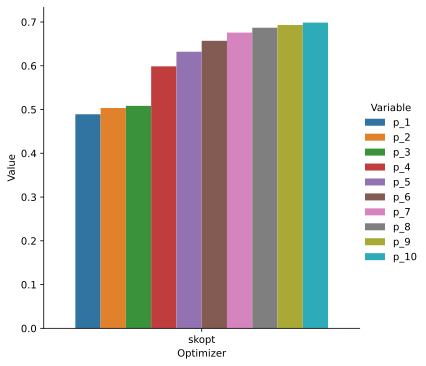

In [66]:
y = "opt obj value"
optimizer = "skopt"
df = pd.DataFrame(np.array(data_final[y].values/result.eigenvalue.real))
df.columns = ['a']
df.index += 1
df = df.T
df.columns = ["p_"+str(i) for i in range(1,11)]
df['optimizer'] = [optimizer]
print (df)
solts=  df.melt(id_vars='optimizer').rename(columns=str.title)
titanic = sns.load_dataset("titanic")
sns.catplot(x="Optimizer", y="Value",  hue='Variable', kind="bar", data=solts)